In [4]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

1. Import claims_data.csv and cust_data.csv which is provided to you and 
combine the two datasets appropriately to create a 360-degree view of 
the data. Use the same for the subsequent questions.


In [5]:
claims=pd.read_csv(r'C:\Users\nagar\Documents\python files\project\Case Study 3 - Insurance Claims Case Study\claims.csv')
cusdemo=pd.read_csv(r'C:\Users\nagar\Documents\python files\project\Case Study 3 - Insurance Claims Case Study\cust_demographics.csv')

In [6]:
cust=pd.merge(cusdemo,claims,how='left',left_on='CUST_ID',right_on='customer_id')

-2. Perform a data audit for the datatypes and find out if there are any 
mismatch within the current datatypes of the columns and their 
business significance.

In [7]:

cust['Contact']=cust['Contact'].str.replace('-','')
cust=cust.astype({
    'DateOfBirth':'datetime64[ns]',
    'Contact':'str',
    'claim_id':'str',
    'customer_id':'str',
    'claim_date':'datetime64[ns]'
})

-3. Convert the column claim_amount to numeric. Use the appropriate 
modules/attributes to remove the $ sign.

In [8]:
cust['claim_amount']=cust['claim_amount'].str.replace('$','').astype('float')

-4. Of all the injury claims, some of them have gone unreported with the 
police. Create an alert flag (1,0) for all such claims.

In [9]:
cust['flag']=cust.loc[cust['claim_type']=='Injury only','police_report'].apply(lambda x:1 if x=='No' else 0)

In [10]:
cust.flag=cust.flag.fillna(0)

-5. One customer can claim for insurance more than once and in each claim,
multiple categories of claims can be involved. However, customer ID 
should remain unique.

In [11]:
cust.customer_id.drop_duplicates()

0       21868593.0
1       75740424.0
2       30308357.0
4       47830476.0
6       19269962.0
           ...    
1087    79539873.0
1088    42364152.0
1089    19888166.0
1090    11256802.0
1091    61575264.0
Name: customer_id, Length: 1079, dtype: object

-6. Check for missing values and impute the missing values with an 
appropriate value. (mean for continuous and mode for categorical

In [12]:
ran1=cust.select_dtypes('number')[['CUST_ID', 'claim_amount', 'total_policy_claims', 'flag']]
for i in ran1.columns:
    ran1[i].fillna(ran1[i].mean(),inplace=True)

In [13]:
ran2=cust.select_dtypes(include=['object','datetime']).copy()
for i in ran2.columns:
    mod=ran2[i].mode()[0]
    ran2[i].fillna(mod,inplace=True)
    

In [14]:
cust1=pd.concat([ran1,ran2],axis=1)

7. Calculate the age of customers in years. Based on the age, categorize the
customers according to the below criteria
Children < 18
Youth 18-30
Adult 30-60
Senior > 60

In [15]:
cust['age']=cust['DateOfBirth'].apply(lambda x:pd.Timestamp.now()-x).dt.days//365

In [16]:
def cate(age):
    if age<18:
        return 'children'
    elif age<31:
        return 'Youth'
    elif age<61:
        return 'Adult'
    else:
        return 'Senior'

In [17]:
cust['category']=cust['age'].apply(cate)

-8. What is the average amount claimed by the customers from various 
segments?

In [19]:
cust.groupby('Segment')['claim_amount'].agg('mean').reset_index()

,Segment,claim_amount
0,Gold,12852.189802
1,Platinum,12336.517291
2,Silver,12185.751562


-9. What is the total claim amount based on incident cause for all the claims
that have been done at least 20 days prior to 1st of October, 2018.

In [16]:
cutdate=pd.to_datetime('2018-10-01')
offdate=cutdate-pd.DateOffset(days=20)

In [17]:
fine1=cust[cust['claim_date']>offdate]
fine1.groupby('incident_cause')['claim_amount'].sum().round(2).reset_index()

,incident_cause,claim_amount
0,Crime,34790.0
1,Driver error,228080.0
2,Natural causes,59584.5
3,Other causes,487276.0
4,Other driver error,228154.0


-10. How many adults from TX, DE and AK claimed insurance for driver 
related issues and causes?

In [18]:
pri=len(cust[(cust['State'].isin(['TX','DE','AK'])) & (cust['category']=='Adult') & (cust['incident_cause']=='Driver error')])
print(f'there are {pri} people from  from TX, DE and AK claimed insurance for driver related issues and causes')

there are 10 people from  from TX, DE and AK claimed insurance for driver related issues and causes


-11. Draw a pie chart between the aggregated value of claim amount based 
on gender and segment. Represent the claim amount as a percentage on
the pie chart.

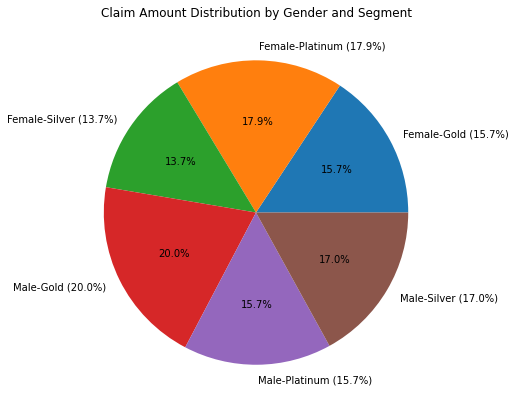

In [19]:
pre1=cust.groupby(['gender','Segment'])['claim_amount'].sum().reset_index()
pie_data=pre1.reset_index()
pie_data['Percentage']=pie_data['claim_amount']/pie_data['claim_amount'].sum() * 100
plt.figure(figsize=(10, 7))
plt.pie(pie_data['claim_amount'], labels=pie_data.apply(lambda x: f"{x['gender']}-{x['Segment']} ({x['Percentage']:.1f}%)", axis=1),autopct='%1.1f%%')
plt.title('Claim Amount Distribution by Gender and Segment')
plt.show()

-12. Among males and females, which gender had claimed the most for any 
type of driver related issues? E.g. This metric can be compared using a 
bar chart

In [20]:
twelve=cust[cust['incident_cause'].isin(['Driver error','Other driver error'])]

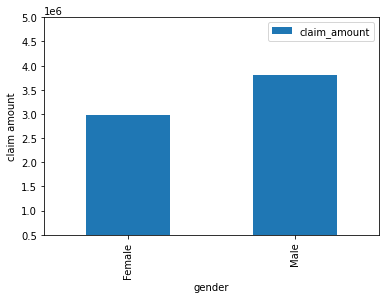

In [21]:
tww1=twelve.groupby('gender')['claim_amount'].sum().reset_index()
tww1.plot(kind='bar',x='gender')
plt.ylim(500000,5000000)
plt.xlabel('gender')
plt.ylabel('claim amount')
plt.show()

In [22]:
##its clear that, Male claimed most of the driver and driver related insurance amount

-13. Which age group had the maximum fraudulent policy claims? Visualize 
it on a bar chart.


<AxesSubplot:>

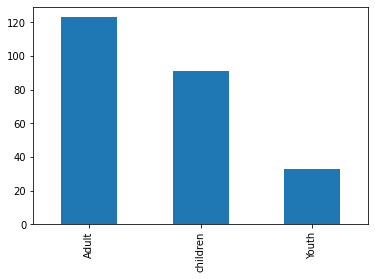

In [23]:
thirt=cust[cust['fraudulent']=='Yes'].category.value_counts()
thirt.plot(kind='bar',x='category')

In [24]:
##Adults are more in doing fraud for claiming insurance amount then rest of the age

-14. Visualize the monthly trend of the total amount that has been claimed 
by the customers. Ensure that on the “month” axis, the month is in a 
chronological order not alphabetical order.

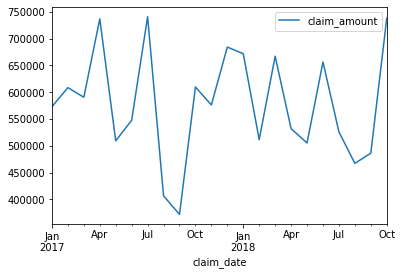

In [25]:
fotyn=cust.groupby(pd.Grouper(key='claim_date',freq='M'))['claim_amount'].sum().reset_index()
fotyn.plot(kind='line',x='claim_date')
plt.show()

-15. What is the average claim amount for gender and age categories and 
suitably represent the above using a facetted bar chart, one facet that 
represents fraudulent claims and the other for non-fraudulent claim

In [26]:
fiftyn=cust.groupby(['gender','category','fraudulent'])['claim_amount'].mean().reset_index()

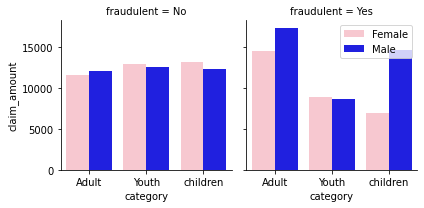

In [27]:
face=sns.FacetGrid(fiftyn, col='fraudulent')
face.map_dataframe(sns.barplot,x='category',y='claim_amount',hue='gender',palette={'Male':'blue','Female':'Pink'})
plt.legend()

In [28]:
##Based on the conclusions from exploratory analysis as well as suitable 
##statistical tests, answer the below questions. Please include a detailed 
##write-up on the parameters taken into consideration, the Hypothesis 
##testing steps, conclusion from the p-values and the business implications of 
##the statements. 

In [29]:
import scipy.stats as stats

In [30]:
##16. Is there any similarity in the amount claimed by males and females?

In [31]:
##H0 Both dont Men and Women claims eqaul amount of insurance money
##H1 THey  claims eqaul amount of insurance money

maleclaim=cust.loc[cust.gender=='Male','claim_amount'].dropna()
femaleclaim=cust.loc[cust.gender=='Female','claim_amount'].dropna()
##confidence level-95%
##pvalue critical-5%

##test kind Ttest
stats.ttest_ind(femaleclaim,maleclaim)


Ttest_indResult(statistic=-0.9736692358288354, pvalue=0.33045209541751097)

In [32]:
##People of both genders are'nt claiming eqaul amount of insurance money and null hypothesis is true

In [33]:
##17. Is there any relationship between age category and segment?

In [34]:
##H0-theres' no relationship
##H1-theres' relationship
##confidence level-95%
##acceptance level -5%
##test? chi-quared

sevtyn=pd.crosstab(cust.Segment,cust.category)
stats.chi2_contingency(sevtyn)

(1.1863554746819438,
 0.8803399505513062,
 4,
 array([[180.42490842,  64.38827839, 131.18681319],
        [175.14652015,  62.50457875, 127.3489011 ],
        [168.42857143,  60.10714286, 122.46428571]]))

In [35]:
    ##ther is no relation between segment or age category, so we failed to reject null hypothesis

In [36]:
##18. The current year has shown a significant rise in claim amounts as 
##compared to 2016-17 fiscal average which was $10,000

In [37]:
##assume that the current fiscal is 2017-2018
##H0-theres' no significance rise in claim amount this year
##H1-theres' significance rise in claim amount this year
##confidence level-95%
##acceptance level -5%
Y2017=cust.loc[cust.claim_date.dt.year==2017,'claim_amount'].dropna()
curr_year=10000
a,p_value=stats.ttest_1samp(Y2017,curr_year)
p_value.round(4)

0.0001

In [38]:
##we reject the null hypothesis. Theres is increase in claim amount from 2017

In [39]:
##19. Is there any difference between age groups and insurance claims


In [40]:
observe=pd.crosstab(cust.claim_type,cust.category)

In [41]:
## H0: there is no relationship
## Ha: there is a relationship
##confidence level-95%
##acceptance level -5%
## test? chi2 test

stats.chi2_contingency(observe)

(4.817514982086259,
 0.30653919936022533,
 4,
 array([[ 93.4562212 ,  33.24884793,  68.29493088],
        [113.58525346,  40.41013825,  83.00460829],
        [312.95852535, 111.34101382, 228.70046083]]))

In [42]:
##we failed to reject null hypthesis. There exists a relation between age group and insurance claims

In [43]:
##20. Is there any relationship between total number of policy claims and the claimed amount?

In [114]:
claim_sum=cust.groupby('claim_area')['claim_amount'].agg(['sum']).reset_index()
claim_count=cust.groupby('claim_area')['claim_amount'].count().reset_index()
claim_sum=claim_sum.select_dtypes('number')
claim_count=claim_count.select_dtypes('number')

In [115]:
##H0- Theres' no relationship between count of policy claims and claimed amount
##H1- Theres' relation betweeen count of policy claims and cliamed amount
##confidence level-95%
##acceptance level -5%
##test kind? ttest
stats.ttest_ind(claim_count,claim_sum)

Ttest_indResult(statistic=array([-1.22457429]), pvalue=array([0.34539844]))

In [118]:
##we fail to reject null hypothesis and there is no relationship between claim amount and number of times insurace claimed

,CUST_ID,gender,DateOfBirth,State,Contact,Segment,claim_id,customer_id,incident_cause,claim_date,claim_area,police_report,claim_type,claim_amount,total_policy_claims,fraudulent,flag
0,21868593,Female,1979-01-12,VT,7899168172,Platinum,54004764.0,21868593.0,Driver error,2017-11-27,Auto,No,Material only,2980.0,1.0,No,0.0
1,75740424,Female,2070-01-13,ME,2655431264,Silver,33985796.0,75740424.0,Crime,2018-10-03,Home,Unknown,Material only,2980.0,3.0,No,0.0
2,30308357,Female,1984-03-11,TN,7986314758,Silver,53522022.0,30308357.0,Other driver error,2018-02-02,Auto,No,Material only,3369.5,1.0,Yes,0.0
3,30308357,Female,1984-03-11,TN,7986314758,Silver,63017412.0,30308357.0,Driver error,2018-04-04,Auto,No,Material only,1950.0,6.0,No,0.0
4,47830476,Female,1986-05-01,MA,4131877945,Silver,13015401.0,47830476.0,Natural causes,2018-06-17,Auto,No,Material only,1680.0,1.0,No,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1087,79539873,Female,1981-03-15,ND,4594254319,Platinum,62020796.0,79539873.0,Other driver error,2018-09-06,Auto,Yes,Material only,1770.0,1.0,No,0.0
1088,42364152,Female,1996-07-07,ID,5294621635,Silver,63269067.0,42364152.0,Other causes,2017-05-09,Home,No,Material only,2800.0,1.0,No,0.0
1089,19888166,Male,1990-04-11,WI,7126519613,Gold,22690595.0,19888166.0,Other driver error,2017-05-15,Auto,Yes,Injury only,33080.0,2.0,No,0.0
1090,11256802,Female,2064-10-22,LA,4693455617,Silver,12376894.0,11256802.0,Other driver error,2017-04-18,Auto,No,Material only,2840.0,4.0,No,0.0
